# Let's Dive into CNNs
## Please read the following paragraph I copy-pasted from ChatGPT:
Welcome back to the exciting world of Convolutional Neural Networks (CNN), building on our previous question which focused on Multilayer Perceptrons (MLP)! As you already know, CNNs are a powerful tool for image and video processing applications. They are designed to recognize patterns and features in visual data, making them a popular choice in computer vision research. One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data, which preserves spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

One of the reasons why CNNs are preferred over MLPs for image recognition tasks is their ability to handle high-dimensional input data. MLPs are limited in their ability to process images because they require that the input data be flattened into a one-dimensional vector, which can result in a loss of important spatial information. In contrast, CNNs are designed to handle multi-dimensional data such as images, preserving spatial information by applying convolutional filters to detect patterns and features at different locations in the input data.

In this assignment, we will be playing with the CIFAR-10 dataset to explore different CNN models. We will start by training an auto-encoder for CIFAR images. This auto-encoder will allow us to compare different models, including a Multilayer Perceptron (MLP) model, a CNN-MLP mixed model, and finally a CNN-only model. By comparing the performance of these models, we can gain a deeper understanding of the importance of CNN layers in image processing tasks.

Once we've completed our auto-encoder experiments, we will use the encoder from the best-performing model to train a Siamese network. Siamese networks are a type of neural network that can recognize similarity between two images, making them a popular choice for tasks such as image retrieval and face recognition. By training a Siamese network using the CIFAR-10 dataset, we can gain a better understanding of how CNNs can be used in more complex image recognition tasks.

Overall, this assignment will allow us to explore the many different applications of CNNs in image processing tasks. We'll have the opportunity to experiment with different architectures, compare their performance, and gain valuable insights into how CNNs can be used to solve real-world problems.

🫵Pro-tip: Utilize learnings from previous question to better solve problems in this question.

💭Trivia: Yes, I am allowed use ChatGPT!

## Part 0: Initialization
### Step zero: Import Libraries

In [3]:
# code here
# code here
import torch
from torchvision import datasets, transforms
import numpy as np
import torchvision
import os
import torchvision.transforms as transforms
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
 
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torch.autograd import Variable
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

### Step one: Using a PyTorch Dataset
Load CIFAR-10 dataset from `torchvision.datasets`. Keep batch_size >= 16.

In [4]:
# code here
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                      download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                        shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
          'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


torch.Size([4, 3, 32, 32])
torch.Size([4])


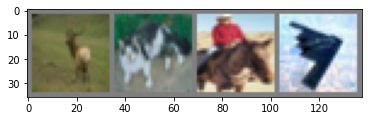

 deer   cat horse plane


In [6]:
# let's have a look at the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Iterate over the data loader to get a batch of images and labels
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## Part 1: Auto-Encoder
### Step one: Define 3 Models for Auto-Encoder
1. MLP-only model
2. CNN-MLP combination model
3. CNN-only model

In all the models, encoder and decoder should be consisting of $3$ layers each, and the encoder should be giving a flattened representation of size $32$.

Please see that each layer of encoder should decrease or keep equal the output size as compared to input size. Similarly, each layer of decoder should increase or keep equal the output size as compared to input size. 

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class MLPAutoEncoder(nn.Module):
    def __init__(self):
        super(MLPAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(3 * 32 * 32, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Linear(256, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 32))
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 3 * 32 * 32),
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class ComboAutoEncoder(nn.Module):
    def __init__(self):
        super(ComboAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(4 * 4 * 4, 32))
        self.decoder = nn.Sequential(
            nn.Linear(32, 4 * 4 * 4),
            nn.ReLU(True),
            nn.Unflatten(1, (4, 4, 4)),
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Tanh())
        
    def forward(self, x):
      x = self.encoder(x)
      x = self.decoder(x)
      return x

class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
         # Encoder layers
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(8, 4, kernel_size=3, padding=1)
        
        # Decoder layers
        self.conv4 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv5 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv6 = nn.Conv2d(16, 3, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Encoder
        x = nn.functional.relu(self.conv1(x))
        x = self.pool1(x)
        x = nn.functional.relu(self.conv2(x))
        x = self.pool2(x)
        x = nn.functional.relu(self.conv3(x))
        
        # Decoder
        x = nn.functional.relu(self.conv4(x))
        x = self.upsample1(x)
        x = nn.functional.relu(self.conv5(x))
        x = self.upsample2(x)
        x = torch.tanh(self.conv6(x))
        return x

### Step two: Using MSELoss, train all the models and analyse results
Make sure you also discuss size, time-taken and any other differences you found. Plot MSELoss for each epoch for all models. Also, tabulate the final MSELosses of all models and plot it vis-a-vis:

1. Model Size
2. Model Parameters
3. Time Taken per epoch 

In [43]:
# code here
model1 = MLPAutoEncoder().cuda()
criterion1 = nn.MSELoss()
optimizer1 = optim.Adam(model1.parameters(), lr=0.001)

for epoch in range(3): # Number of epochs
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        inputs, _ = data
        inputs = inputs.view(inputs.size(0), -1)
        optimizer1.zero_grad()
        inputs = Variable(inputs).data.cuda()
        outputs = model1(inputs)
        loss = criterion1(outputs, inputs)
        loss.backward()
        optimizer1.step()

        running_loss += loss.item()
    print('Epoch [%d], Loss: %.4f' % (epoch+1, running_loss/len(trainloader)))

print('Finished Training')

Epoch [1], Loss: 0.1355
Epoch [2], Loss: 0.1203
Epoch [3], Loss: 0.1150
Finished Training


In [46]:
model2 = ComboAutoEncoder().cuda()

# Define the loss function and optimizer
criterion2 = nn.MSELoss()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)

# Train the model
for epoch in range(3):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        optimizer2.zero_grad()
        inputs = Variable(inputs).data.cuda()
        outputs = model2(inputs)
        loss = criterion2(outputs, inputs)
        loss.backward()
        optimizer2.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(trainloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 3, epoch_loss))

Epoch [1/3], Loss: 0.0892
Epoch [2/3], Loss: 0.0740
Epoch [3/3], Loss: 0.0710


In [11]:
model3 = CNNAutoEncoder().cuda()

# Define the loss function and optimizer
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# Train the model
for epoch in range(3):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        optimizer3.zero_grad()
        inputs = Variable(inputs).data.cuda()
        outputs = model3(inputs)
        loss = criterion3(outputs, inputs)
        loss.backward()
        optimizer3.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(trainloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 3, epoch_loss))

Epoch [1/3], Loss: 0.0293
Epoch [2/3], Loss: 0.0198
Epoch [3/3], Loss: 0.0184


GroundTruth:    cat  ship  ship plane


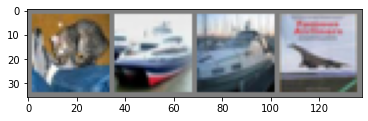

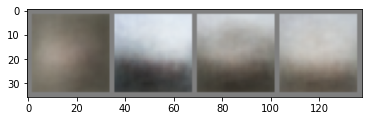

GroundTruth:    cat  ship  ship plane


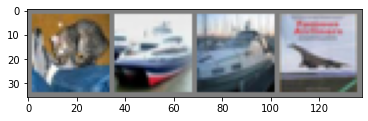

Reconstructed image


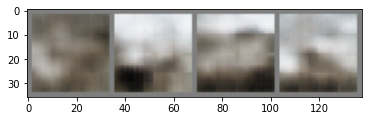

GroundTruth:    cat  ship  ship plane


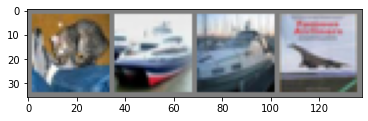

Reconstructed image


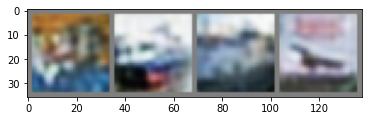

In [47]:
# Utilize the following code
#--------------MLP--------------#
dataiter = iter(testloader)
for images, labels in testloader:
    break
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(images))
images = images.cuda()
images_flatten = images.view(images.size(0), -1)
reconstructed_images = model1(images_flatten)
reconstructed_images = reconstructed_images.view(-1, 3, 32, 32)
imshow(torchvision.utils.make_grid(reconstructed_images.cpu().detach()))
# #--------------Combo--------------#
dataiter = iter(testloader)
imgs, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(imgs))

imgs = Variable(imgs).cuda()

print("Reconstructed image")
decoded_imgs = model2(imgs)
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

# #--------------CNN--------------#
dataiter = iter(testloader)
imgs, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(imgs))

imgs = Variable(imgs).cuda()

print("Reconstructed image")
decoded_imgs = model3(imgs)
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

### Step three: Let's play with Representation Sizes
Spoilers: You must have found CNN to be more effective.

Have you ever wondered how varying the size of a CNN auto-encoder's representation can affect its performance? If so, here's a challenge for you: Implement a CNN auto-encoder with different representation sizes and observe the impact on the reconstruction quality.

Play with the following representation sizes:
1. 10
2. 32
3. 100
4. 1000

When working with different representation sizes in a CNN auto-encoder, we may reach a point of diminishing returns where increasing the representation size does not lead to significant improvements in reconstruction quality. This can be due to factors such as increased model complexity and longer training times. Discuss where you feel we might reach this point of diminishing returns when working with CIFAR-10 dataset and varying representation sizes.

Do analysis as suggested earlier.

In [37]:
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
         # Encoder layers
        self.encode = nn.Sequential(
            nn.Conv2d(3, 5, 8, stride=6, padding=0),
            nn.ReLU(),
            nn.Conv2d(5, 8, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 10, 4, stride=3, padding=1),
            nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(10, 8, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 5, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(5, 3, 8, stride=6, padding=0),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [39]:
model3 = CNNAutoEncoder().cuda()

# Define the loss function and optimizer
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# Train the model
for epoch in range(3):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        optimizer3.zero_grad()
        inputs = Variable(inputs).data.cuda() 
        outputs = model3(inputs)
        loss = criterion3(outputs, inputs)
        loss.backward()
        optimizer3.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(trainloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 3, epoch_loss))

Epoch [1/3], Loss: 0.0300
Epoch [2/3], Loss: 0.0197
Epoch [3/3], Loss: 0.0183


GroundTruth:    cat  ship  ship plane


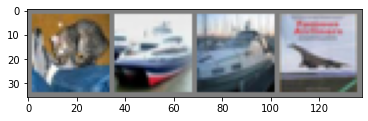

Reconstructed image


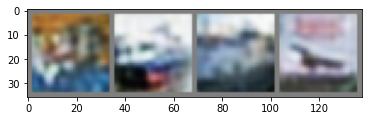

In [45]:
dataiter = iter(testloader)
imgs, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(imgs))

imgs = Variable(imgs).cuda()

print("Reconstructed image")
decoded_imgs = model3(imgs)
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

In [ ]:
# code and analysis here
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
         # Encoder layers
        self.encode = nn.Sequential(
            nn.Conv2d(3, 12, 8, stride=6, padding=0),
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(24, 32, 4, stride=3, padding=1),
            nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(32, 24, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(24, 12, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 8, stride=6, padding=0),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
model3 = CNNAutoEncoder().cuda()

# Define the loss function and optimizer
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# Train the model
for epoch in range(3):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        optimizer3.zero_grad()
        inputs = Variable(inputs).data.cuda() 
        outputs = model3(inputs)
        loss = criterion3(outputs, inputs)
        loss.backward()
        optimizer3.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(trainloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 3, epoch_loss))

In [ ]:
dataiter = iter(testloader)
imgs, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(imgs))

imgs = Variable(imgs).cuda()

print("Reconstructed image")
decoded_imgs = model3(imgs)
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

In [64]:
# code and analysis here
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
         # Encoder layers
        self.encode = nn.Sequential(
            nn.Conv2d(3, 2**5, 8, stride=6, padding=0),
            nn.ReLU(),
            nn.Conv2d(2**5, 2**6, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2**6, 10**2, 4, stride=3, padding=1),
            nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(10**2, 2**6, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**6, 2**5, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**5, 3, 8, stride=6, padding=0),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [65]:
model3 = CNNAutoEncoder().cuda()

# Define the loss function and optimizer
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# Train the model
for epoch in range(3):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        inputs = Variable(inputs).data.cuda() 
        outputs = model3(inputs)
        loss = criterion3(outputs, inputs)
        optimizer3.zero_grad()
        loss.backward()
        optimizer3.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(trainloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 3, epoch_loss))

Epoch [1/3], Loss: 0.1754
Epoch [2/3], Loss: 0.1645
Epoch [3/3], Loss: 0.1620


GroundTruth:    cat  ship  ship plane


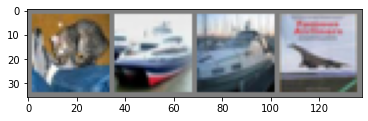

Reconstructed image


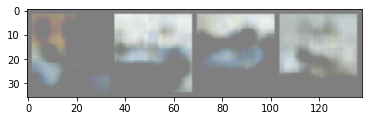

In [66]:
dataiter = iter(testloader)
imgs, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(imgs))

imgs = Variable(imgs).cuda()

print("Reconstructed image")
decoded_imgs = model3(imgs)
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

In [ ]:
# code and analysis here
class CNNAutoEncoder(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()
         # Encoder layers
        self.encode = nn.Sequential(
            nn.Conv2d(3, 2**7, 8, stride=6, padding=0),
            nn.ReLU(),
            nn.Conv2d(2**7, 2**9, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2**9, 10**3, 4, stride=3, padding=1),
            nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(10**3, 2**9, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**9, 2**7, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**7, 3, 8, stride=6, padding=0),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [ ]:
model3 = CNNAutoEncoder().cuda()

# Define the loss function and optimizer
criterion3 = nn.MSELoss()
optimizer3 = optim.Adam(model3.parameters(), lr=0.001)

# Train the model
for epoch in range(3):
    running_loss = 0.0
    for data in trainloader:
        inputs, _ = data
        optimizer3.zero_grad()
        inputs = Variable(inputs).data.cuda() 
        outputs = model3(inputs)
        loss = criterion3(outputs, inputs)
        loss.backward()
        optimizer3.step()
        running_loss += loss.item() * inputs.size(0)
        
    epoch_loss = running_loss / len(trainloader.dataset)
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 3, epoch_loss))

In [ ]:
dataiter = iter(testloader)
imgs, labels = next(dataiter)
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
imshow(torchvision.utils.make_grid(imgs))

imgs = Variable(imgs).cuda()

print("Reconstructed image")
decoded_imgs = model3(imgs)
imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

### Step four: What about the number of layers?

Experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder can have a significant impact on its performance with CIFAR-10 dataset. For our next challenge, let's explore how the number of layers can affect the quality of the reconstructed images. Would a deeper or shallower network be more effective for this task?

Play with the following numbers of layers for encoder and decoder each:
1. 1
2. 3
3. 5
4. 10

When experimenting with different numbers of layers in the encoder and decoder of a CNN auto-encoder, we may reach a point of diminishing returns where adding more layers does not result in significant improvements in reconstruction quality. Additionally, deeper networks may be prone to overfitting, especially when training data is limited. Discuss where you feel we reach it. 

Do analysis as suggested earlier.

In [58]:
# code and analysis here
# code and analysis here
class CNNAutoEncoder1(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder1, self).__init__()
         # Encoder layers
        self.encode = nn.Sequential(
            nn.Conv2d(3, 10**2, 2**5, stride=1, padding=1),
            nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(10**2, 3, 2**5, stride=1, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [59]:
# code and analysis here
# code and analysis here
class CNNAutoEncoder2(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder2, self).__init__()
         # Encoder layers
        self.encode = nn.Sequential(
            nn.Conv2d(3, 2**5, 8, stride=6, padding=0),
            nn.ReLU(),
            nn.Conv2d(2**5, 2**6, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(2**6, 10**2, 4, stride=3, padding=1),
            nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(10**2, 2**6, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**6, 2**5, 4, stride=3, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**5, 3, 8, stride=6, padding=0),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [60]:
# code and analysis here
# code and analysis here
class CNNAutoEncoder3(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder3, self).__init__()
         # Encoder layers
        self.encode = nn.Sequential(
            nn.Conv2d(3, 3*4, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(3*4, 2**5, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(2**5, 2**6, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(2**6, 2**6, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(2**6, 10**2, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(10**2, 2**6, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**6, 2**6, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**6, 2**5, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(2**5, 3*4, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(3*4, 3, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

In [61]:
# code and analysis here
# code and analysis here
class CNNAutoEncoder4(nn.Module):
    def __init__(self):
        super(CNNAutoEncoder4, self).__init__()
         # Encoder layers
        self.encode = nn.Sequential(
            nn.Conv2d(3, 8, 2, stride=2, padding=12),
            nn.ReLU(),
            nn.Conv2d(8, 3*4, 2, stride=2, padding=10),
            nn.ReLU(),
            nn.Conv2d(3*4, 2**4, 2, stride=2, padding=8),
            nn.ReLU(),
            nn.Conv2d(2**4, 2**5, 2, stride=2, padding=8),
            nn.ReLU(),
            nn.Conv2d(2**5, 45, 2, stride=2, padding=7),
            nn.ReLU(),
            nn.Conv2d(45, 2**6, 2, stride=2, padding=4),
            nn.ReLU(),
            nn.Conv2d(2**6, 75, 2, stride=2, padding=4),
            nn.ReLU(),
            nn.Conv2d(75, 85, 2, stride=2, padding=3),
            nn.ReLU(),
            nn.Conv2d(85, 95, 2, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(95, 25, 1, stride=3, padding=0),
            nn.ReLU(),
        )
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(25, 95, 1, stride=3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(95, 85, 2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(85, 75, 2, stride=2, padding=3),
            nn.ReLU(),
            nn.ConvTranspose2d(75, 2**6, 2, stride=2, padding=4),
            nn.ReLU(),
            nn.ConvTranspose2d(2**6, 45, 2, stride=2, padding=4),
            nn.ReLU(),
            nn.ConvTranspose2d(45, 2**5, 2, stride=2, padding=7),
            nn.ReLU(),
            nn.ConvTranspose2d(2**5, 2**4, 2, stride=2, padding=8),
            nn.ReLU(),
            nn.ConvTranspose2d(2**4, 3*4, 2, stride=2, padding=8),
            nn.ReLU(),
            nn.ConvTranspose2d(3*4, 8, 2, stride=2, padding=10),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, 2, stride=2, padding=12),
            nn.ReLU(),
        )
        
    def forward(self, x):
        return self.decode(self.encode(x))

Epoch [1/3], Loss: 0.2134
Epoch [2/3], Loss: 0.2105
Epoch [3/3], Loss: 0.2123
GroundTruth:    cat  ship  ship plane


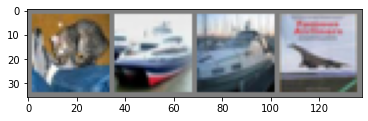

Reconstructed image


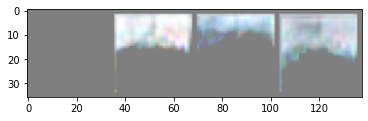

Epoch [1/3], Loss: 0.1780
Epoch [2/3], Loss: 0.1674
Epoch [3/3], Loss: 0.1645
GroundTruth:    cat  ship  ship plane


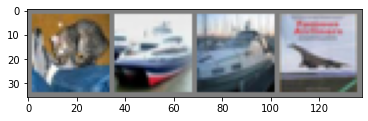

Reconstructed image


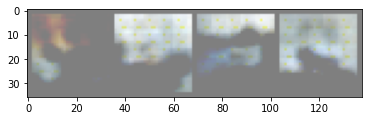

Epoch [1/3], Loss: 0.1828
Epoch [2/3], Loss: 0.1696
Epoch [3/3], Loss: 0.1658
GroundTruth:    cat  ship  ship plane


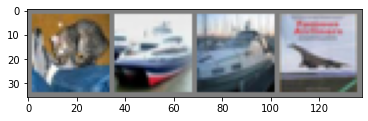

Reconstructed image


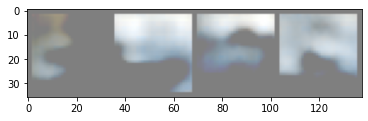

KeyboardInterrupt: ignored

In [63]:
model1 = CNNAutoEncoder1().cuda()
model2 = CNNAutoEncoder2().cuda()
model3 = CNNAutoEncoder3().cuda()
model4 = CNNAutoEncoder4().cuda()

models = [model1,model2,model3,model4]

for model in models:
  # Define the loss function and optimizer
  criterion3 = nn.MSELoss()
  optimizer3 = optim.Adam(model.parameters(), lr=0.001)

  # Train the model
  for epoch in range(3):
      running_loss = 0.0
      for data in trainloader:
          inputs, _ = data
          optimizer3.zero_grad()
          inputs = Variable(inputs).data.cuda() 
          outputs = model(inputs)
          loss = criterion3(outputs, inputs)
          loss.backward()
          optimizer3.step()
          running_loss += loss.item() * inputs.size(0)
          
      epoch_loss = running_loss / len(trainloader.dataset)
      print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 3, epoch_loss))

  dataiter = iter(testloader)
  imgs, labels = next(dataiter)
  print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
  imshow(torchvision.utils.make_grid(imgs))

  imgs = Variable(imgs).cuda()

  print("Reconstructed image")
  decoded_imgs = model(imgs)
  imshow(torchvision.utils.make_grid(decoded_imgs.data.cpu()))

In [ ]:
# explainations here

## Part 2: The return of kNN
Autoencoder representations can be useful for a wide range of machine learning tasks beyond just reconstructing input data. For example, the output of an encoder can be used as a feature representation for classification using k-Nearest Neighbors (kNN) or other classifiers. Similarly, the encoded representations can be used for unsupervised tasks like clustering, where the model groups similar images together based on their feature representation. This makes autoencoders a versatile tool for feature learning, with the potential to enhance the performance of a wide range of machine learning algorithms.

Since we have already trained auto-encoder on CIFAR-10, we will employ the encoder from the CNN model with representation size of $10$. Using a subset of CIFAR-10 train and test datasets, each with 10,000 and 1000 samples respectively, with an equal number of samples for each class, implement kNN classification using the encoder output as features. Share your findings and accuracy, F1 score and other relavant metrics on the test set. What insights can you draw from the results?

You are allowed to use sklearn or any other library for kNN and splitting dataset.

In [75]:
# code and analysis here. Remember to keep your analysis of high quality at all times.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

num_classes = 10
train_smpl_class_size, test_smpl_class_size = 10000, 1000

train_idx = list()
test_idx = list()
for class_label in range(num_classes):
    train_idx += [i for i, label in enumerate(train_dataset.targets) if label == class_label][:train_smpl_class_size]
    test_idx += [i for i, label in enumerate(test_dataset.targets) if label == class_label][:test_smpl_class_size]

train_subset = torch.utils.data.Subset(train_dataset, train_idx)
test_subset = torch.utils.data.Subset(test_dataset, test_idx)

Files already downloaded and verified
Files already downloaded and verified


In [76]:
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(test_subset, batch_size=16, shuffle=False)

In [77]:
class CNN_KNN(nn.Module):
    def __init__(self):
        super(CNN_KNN, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 10)
        )
    def forward(self, x):
        return self.encode(x)

encoder = CNN_KNN()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

train_featr, test_featr, train_lbl, test_lbl = list(), list(), list(), list()

with torch.no_grad():
    encoder.eval()

    for images, labels in trainloader:
        train_lbl.append(labels)
        features = encoder(images)
        train_featr.append(features)

    train_featr = torch.cat(train_featr, dim=0).numpy()
    train_lbl = torch.cat(train_lbl, dim=0).numpy()

    for images, labels in testloader:
        test_lbl.append(labels)
        features = encoder(images)
        test_featr.append(features)

    test_featr = torch.cat(test_featr, dim=0).numpy()
    test_lbl = torch.cat(test_lbl, dim=0).numpy()

train_featr = train_featr.reshape(train_featr.shape[0], -1)
test_featr = test_featr.reshape(test_featr.shape[0], -1)


In [ ]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(train_featr, train_lbl)

In [ ]:
acc = knn.score(test_featr, test_lbl)
print('Accuracy:', (acc * 100), "%")

## Part 3: Siamese Network (not part of assignment)
Siamese networks are useful for comparing and finding similarities between two inputs. The inputs from identical encoder sub-networks will be given as an input to a dense network (an MLP) and the prediction will be given as output of a Sigmoid function.

Employ the encoder from the best model to be used as the two-identical sub-networks of the Siamese Network. So, copy the weights from the best encoder to the two-identical sub-networks, set the learning rate of this encoder to be lower by a couple of order than that of the dense network.

Who knows, this might be part of next assignment during hectic times. (wink wink)
(Don't quote me on this though)

### Step one: Define a Siamese Network

In [ ]:
# sample.
class SiameseNetwork(nn.Module):
    def __init__(self, encoder):
        super().__init__()
        self.encoder1 = encoder
        self.encoder2 = encoder
        self.decoder = nn.Sequential(
            nn.Linear(2048,1024),
            # whatever
        )

    def forward(self, x1, x2):
        encoded1 = self.encoder1(x1)
        encoded2 = self.encoder2(x2)
        return (encoded1,encoded2)
        
    def differentiate(self, x1_embedding, x2_embedding):
        x = torch.cat([x1_embedding,x2_embedding],dim=1)
        return self.decoder(x)


### Step two: Define the following three losses:
1. TripletLoss
2. ContrastiveLoss
3. Regularized Cross Entropy Loss

In [ ]:
# TripletLoss defined as an example
class TripletLoss(nn.Module):
    def __init__(self, margin):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Compute the distances between the anchor, positive, and negative examples
        distance_pos = F.pairwise_distance(anchor, positive, p=2)
        distance_neg = F.pairwise_distance(anchor, negative, p=2)
        # Compute the triplet loss using the margin
        loss_triplet = torch.mean(torch.clamp(distance_pos - distance_neg + self.margin, min=0.0))
        return loss_triplet

In [ ]:
# code here

### Train the Siamese network...
... and write a function that takes 2 inputs and outputs whether they belong to the same class or not. Plot and share the results of the function. The results should contain both successful results, i.e. classification as 'same' for inputs belonging to the same class and classification as 'not-same' for inputs belonging to different classes, as well as some unsuccessful results (that gives the wrong output than expected).
Provide an explanation of why the unsuccessful results might occur.

In [ ]:
# code and analysis here

### And again. What did we learn?
Discuss any and all learnings here. The discussions must be all-encompassing so that we know what did you learn. 

To re-iterate: "Please do not copy from your friend or copy-paste from the internet. We can see repetitions during evaluations."